## Azimuthal Dust Profiles

In [1]:
import numpy as np  
import matplotlib.pyplot as plt  
import astropy.constants as c  
import astropy.units as u  
%matplotlib inline

au = c.au.cgs.value
c_light = c.c.cgs.value

jy_as = (1. * u.Jy / u.arcsec).cgs.value

In [2]:
import azimuthal_profile as az
import dsharp_opac as op
from scipy.interpolate import interp2d

### Set up model parameters of a radial gas profile

In [3]:
na          = 100
ny          = 400 
A_gas       = 1.2    # gas density contrast (peak-to-valley)
sigma_y_deg = 10     # azimuthal bump extent in degree
d2g         = 1e-2
alpha       = 1e-3
v_frag      = 1000.
rho_s       = 1.67
M_star      = c.M_sun.cgs.value


sigma_y = sigma_y_deg / 180 * np.pi
r       = np.array([30 * au])                # radial grid
Y       = r[:, None] * np.linspace(- np.pi, np.pi, ny)  # azimuth grid
A       = np.logspace(-4, 0, na)             # particle size grid
sig_g   = 200 / (r / au)                     # avg. gas surface density
sig_d   = d2g * sig_g
T       = 200 * (r / au)**-0.5

sig_g_2D = 1 + (A_gas - 1) * np.exp(- Y**2 / (2 * (r * sigma_y))**2)
sig_g_2D *= sig_g / sig_g_2D.mean()

### Get the equilibrium dust distribution

In [4]:
sig_d_2D = az.make_azim_distri(
    r,
    Y,
    A,
    T,
    sig_g_2D,
    sig_d,
    alpha,
    v_frag,
    rho_s,
    M_star,
)

Fitting ... Done!


### Plot the azimuthal distribution of grains

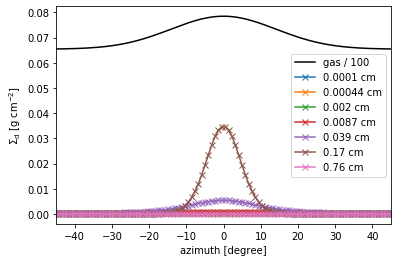

In [5]:
f, ax = plt.subplots()

y = Y[0, :] / r * 180 / np.pi # azimuthal grid in degree

ax.plot(y, sig_g_2D[0, :] / 100, 'k-', label='gas / 100')

for ia in np.arange(na)[::na//6]:
    ax.plot(y, sig_d_2D[0, :, ia], 'x-', label=f'{A[ia]:.2g} cm')

ax.set_xlim(-45, 45)
ax.set_xlabel('azimuth [degree]')
ax.set_ylabel('$\Sigma_\mathrm{d}$ [g cm$^{-2}$]')
ax.legend();

### Plot the contrast as function of particle size

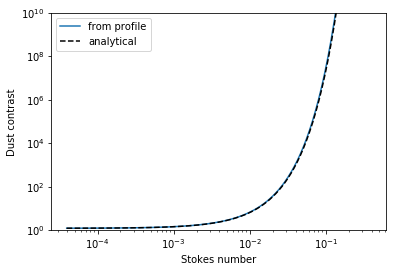

In [6]:
St = A * rho_s * np.pi / (2. * sig_g)
A_d = sig_d_2D.max(-2) / sig_d_2D.min(-2)
A_d_ana = A_gas * np.exp(St * (A_gas - 1) / (A_gas * alpha))

mask = sig_d_2D[0].mean(0)>1e-10

f, ax = plt.subplots()
ax.loglog(St[mask], A_d[0, mask], label='from profile')
ax.loglog(St, A_d_ana, 'k--', label='analytical')

ax.set_xlabel('Stokes number')
ax.set_ylabel('Dust contrast')
ax.legend()
ax.set_ylim(1e0, 1e10);

### Plot the particle size distribution

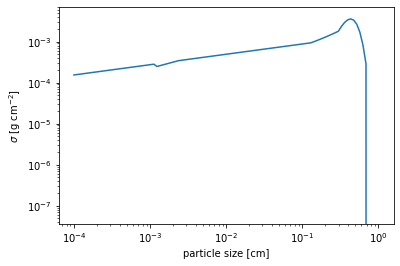

In [7]:
distri = sig_d_2D[0, :, :].mean(0)

f, ax = plt.subplots()

ax.loglog(A, distri)
ax.set_ylim(distri.max() * 1e-5, 2 * distri.max())
ax.set_xlabel('particle size [cm]')
ax.set_ylabel('$\sigma$ [g cm$^{-2}$]');

### Read opacity and interpolate on our grid

In [8]:
lam_obs = np.array([0.13, 0.3, 1]) # our obervational wavelength
n_lam = len(lam_obs)
nu_obs  = c_light / lam_obs

In [9]:
with np.load(op.get_datafile('default_opacities_smooth.npz')) as fid:
    a_opac   = fid['a']
    lam_opac = fid['lam']
    k_abs    = fid['k_abs']
    k_sca    = fid['k_sca']
    g        = fid['g']
    rho_s    = fid['rho_s']

f_kappa = interp2d(np.log10(lam_opac), np.log10(a_opac), np.log10(k_abs))
k_a = 10.**f_kappa(np.log10(lam_obs), np.log10(A))

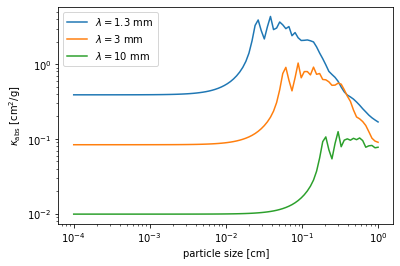

In [10]:
f, ax = plt.subplots()
for ilam in range(n_lam):
    ax.loglog(A, k_a[:, ilam], label=f'$\lambda = {10 * lam_obs[ilam]:.2g}$ mm')
ax.set_xlabel('particle size [cm]')
ax.set_ylabel('$\kappa_\mathrm{abs}$ [cm$^2$/g]')
ax.legend();

### Calculate intensity profile

In [11]:
# tau and I_nu should have shape (n_wavelength, n_radii, n_azimuth)
B_nu = az.planck_B_nu(nu_obs, T)
tau = (sig_d_2D[None,...]*k_a.T[:,None,None,:]).sum(-1)
I_nu = B_nu[:, None, None] * (1 - np.exp(-tau))

Intensity contrast (max/min) at 1.3 mm = 34.3
Intensity contrast (max/min) at 3.0 mm = 193
Intensity contrast (max/min) at 10.0 mm = 588


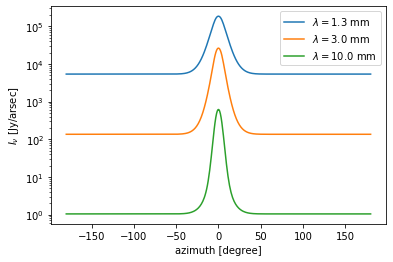

In [12]:
f, ax = plt.subplots()

for ilam in range(n_lam):
    print(f'Intensity contrast (max/min) at {10 * lam_obs[ilam]:3.1f} mm = {I_nu[ilam,...].max()/I_nu[ilam,...].min():.3g}')
    
    ax.semilogy(y, I_nu[ilam, 0, :] / jy_as, label=f'$\lambda = {10 * lam_obs[ilam]:3.1f}$ mm')

ax.set_xlabel('azimuth [degree]')
ax.set_ylabel('$I_\\nu$ [Jy/arsec]')
ax.legend();